In [1]:
import os
from os import listdir
from os.path import isdir, join
import sys

# Setting Directories

In [2]:
data_dir = r'C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline'
#data_dir = '/content/drive/MyDrive/MagNetDrive'  # If using Colab with Google Drive, set this to the location on Drive containing all the data for this project ie '/MyDrive/MagNetDatastore'

# Setting Environment

In [3]:
# Check if the code is running on Google Colab
if 'google.colab' in sys.modules:
    from google.colab import drive
    # Mount Google Drive
    drive.mount('/content/drive')
    # Set the dataset directory path on Google Drive
    data_dir = os.path.join('/content/drive/', data_dir)  # Changes current working directory to Google Drive hosted folder, containing all data and functional scripts
    os.chdir(data_dir)
    platform = "colab"
    print("Running on Google Colab. Google Drive mounted.")
else:
    platform = "local"
    print("Running locally.")


Running locally.


# Loading Training Materials

In [4]:
# get all folders name in current directory
preprocessed_training_dataset_path = os.path.join(data_dir, "preprocessed_training_dataset")

# Initialize the training_materials list
training_materials = []

# Check if the "preprocessed_training_dataset" folder exists
if os.path.exists(preprocessed_training_dataset_path) and os.path.isdir(preprocessed_training_dataset_path):
    # Get the list of materials in the "preprocessed_training_dataset" folder
    subfolders = [item for item in os.listdir(preprocessed_training_dataset_path)
                  if os.path.isdir(os.path.join(preprocessed_training_dataset_path, item))]

    # Check if there are any subfolders
    if subfolders:
        # Save the names of the subfolders to the training_materials list
        training_materials = subfolders
    else:
        print("No training dataset found in dataset directory, preprocessed (normalised, down sampled and split) training materials should be saved into subfolders within a folder called 'preprocessed_training_dataset', where each subfolder is the name of a training material.")
else:
    print("No training dataset found in dataset directory, preprocessed (normalised, down sampled and split) training materials should be saved into subfolders within a folder called 'preprocessed_training_dataset', where each subfolder is the name of a training material.")

# Print the list of training materials if they exist
if training_materials:
    print("Identified training data for materials:", training_materials)

Identified training data for materials: ['3C90', '3C94', '3E6', '3F4', '77', '78', 'N27', 'N30', 'N49', 'N87']


In [5]:
import torch

gpu_num = 0
cuda_ready = False # Track if CUDA hardware acceleration is engaged

if torch.cuda.is_available():
    cuda_ready = True
    print('CUDA available!')
    gpu_num = torch.cuda.device_count()
    if (gpu_num < 1):
        print('GPU unavailable')
    else:
        print('GPU num: ', gpu_num)  # Print number of GPUs
        for gpu in range(gpu_num):
            print('GPU type: ', torch.cuda.get_device_name(gpu))  # Print model of GPU
            print('GPU memory: {:.2f} Gbyte'.format(
                torch.cuda.get_device_properties(gpu).total_memory /
                1e9))  # Print total GPU memory
else:
    cuda_ready = False
    print('CUDA unavailable')

# Check if CUDA is available and if so, set the device to GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = torch.device("cpu")
print("System using ", device)

CUDA unavailable
System using  cpu


# Model Training
First set base material for transfer learning

Base model used for transfer learning found at: C:\Users\ossia\Documents\GitHub\MagLearn-Bristol-2\Single Pipeline\preprocessed_training_dataset\3C90\model_weights.ckpt
Pre-trained model loaded


KeyboardInterrupt: 

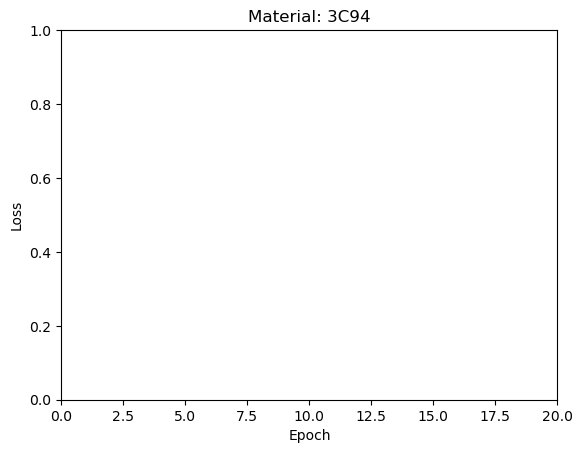

In [8]:
base_mat = "3C90" # This is the base material used to facilitate the first stage of transfer learning as described in the paper, material with largest training dataset selected by default, set as '' to train each material from scratch
model_saved_name = "model_weights.ckpt"

# Setting training period approproate for compute available
if cuda_ready:
    epochs = 500
    valid_batch_size = 3000
else:
    epochs = 20
    valid_batch_size = 1000

from train_model import train_model

if base_mat == '':
    print('Transfer learning function disabled, each material will train from zero initial weightings.')
    for material in training_materials:
        train_model(preprocessed_training_dataset_path, material, base_mat, model_saved_name, device, epochs, valid_batch_size)
elif base_mat in training_materials: # If base training material has been found in directory of training materials
    base_model_path = os.path.join(preprocessed_training_dataset_path, base_mat, model_saved_name)
    if os.path.exists(base_model_path):
        print('Base model used for transfer learning found at:', base_model_path)
        for material in training_materials:
            if material != base_mat: # Prevents pretrained base model from being unnesscesarily retrained
                train_model(preprocessed_training_dataset_path, material, base_mat, model_saved_name, device, epochs, valid_batch_size, verbose=False, load_pretrained=True)
    else:
        print(f"No base model of material {base_mat} found to facilitate transfer learning, program will need to train {base_mat} from scratch before fine-tuning for other materials.")
        train_model(preprocessed_training_dataset_path, base_mat, base_mat, model_saved_name, device, epochs, valid_batch_size, verbose=True) # Trains base material from scratch before transferring it to remaining materials
        for material in training_materials:
            if material != base_mat: # Skips retraining base model
                train_model(preprocessed_training_dataset_path, material, base_mat, model_saved_name, device, epochs, valid_batch_size, verbose=False, load_pretrained=True) # Trains remaining materials using base model as starting point 'fine tuning'
else:
    raise RuntimeError(f"No training data or pretrained model found for material {base_mat}, check that data directory and base material preference is correctly set in beginning of this cell.")